In [1]:
import torch
from torch import optim
from tqdm import tqdm
# Imports for this repository
from simplex_generator import simplex_params
from md_gan_modules import LambdaNetwork, Discriminator, Generator
from gmm_data_generator import load_db
from numpy_dataset import NumpyDataset
from md_gan_training import MDGANTraining,gaussian_likelihood_sum

# Fix Parameters

In [5]:
PARAMS = {'batch_size': 512,
          'zdim': 2,
          'gamma':0.5,
          'beta1':0.5,
          'beta2':0.999,
          'n_lr_steps':3,
          'lambda_training_iterations':10001,
          'epochs':100, #1000
          'eta_lambda': 0.01,
          'e_dim': 9,
          'lr_d': 1e-3,
          'lr_g': 1e-3,
          'epsilon': 1e-8,  # for avoiding numerical instabilities
          'samp_num_gen': 2500}

In [3]:
working_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simplex = simplex_params(PARAMS['e_dim'], working_device) # Create Simplex
print("Current Working Device is set to:" + str(working_device))

Current Working Device is set to:cuda


# Search for $\lambda$

In [ ]:
lambda_net = LambdaNetwork(PARAMS['e_dim']).to(working_device)
lambda_training_data = torch.tensor([1.0], device=working_device, dtype=torch.float32, requires_grad=False)
optimizer_lambda = optim.Adam(lambda_net.parameters(), lr=PARAMS['eta_lambda'])

for i in tqdm(range(PARAMS['lambda_training_iterations'])):
    optimizer_lambda.zero_grad()
    e = lambda_net(lambda_training_data)
    lambda_lk = gaussian_likelihood_sum(e, simplex)
    lambda_loss = -torch.log(PARAMS['epsilon'] + lambda_lk).mean()
    if i % 2500 == 0 and i > 0:
        print("Lambda Loss:" + str(lambda_loss.item()))
        for group in optimizer_lambda.param_groups:
            group['lr'] = group['lr'] * PARAMS['gamma']
    lambda_loss.backward()
    optimizer_lambda.step()
e = lambda_net(lambda_training_data)
lambda_value = gaussian_likelihood_sum(e, simplex).sum().item()
print(lambda_value)

 11%|█         | 1075/10001 [00:02<00:21, 411.65it/s]

Lambda Loss:-3.538745641708374


 21%|██        | 2095/10001 [00:05<00:17, 459.59it/s]

Lambda Loss:-3.538745641708374


 31%|███       | 3075/10001 [00:07<00:15, 441.99it/s]

Lambda Loss:-3.538745641708374


 40%|████      | 4038/10001 [00:09<00:12, 461.01it/s]

Lambda Loss:-3.538745641708374


 50%|█████     | 5045/10001 [00:12<00:13, 370.07it/s]

Lambda Loss:-3.538745641708374


 61%|██████    | 6061/10001 [00:14<00:09, 405.35it/s]

Lambda Loss:-3.538745641708374


 71%|███████   | 7080/10001 [00:16<00:05, 511.30it/s]

Lambda Loss:-3.538745641708374


 81%|████████  | 8077/10001 [00:18<00:05, 383.41it/s]

Lambda Loss:-3.538745641708374


 91%|█████████ | 9059/10001 [00:21<00:02, 396.38it/s]

Lambda Loss:-3.538745641708374


100%|██████████| 10001/10001 [00:23<00:00, 417.17it/s]

Lambda Loss:-3.538745641708374
34.423709869384766


In [4]:
lambda_value = 34.43 # I put it manually here so that I don't have to run the last cell again and again if I didn't change the parameters

# Train Generator and Discriminator

In [6]:
net_g = Generator(PARAMS['zdim']).to(working_device) # Init generator function
net_g.load_state_dict(torch.load("generator_9.pt")) # To be taken out if one wants to start from zero

net_d = Discriminator(PARAMS['e_dim']).to(working_device) # Init discriminator function
optimizer_g = optim.Adam(net_g.parameters(), lr=PARAMS['lr_g'], betas=(PARAMS['beta1'], PARAMS['beta2']))
optimizer_d = optim.Adam(net_d.parameters(), lr=PARAMS['lr_d'], betas=(PARAMS['beta1'], PARAMS['beta2']))

epoch_step_size=PARAMS['epochs']/(PARAMS['n_lr_steps']+1) # calculate learning rate decay step size
lr_steps=[int((i+1)*epoch_step_size) for i in range(PARAMS['n_lr_steps'])] 
print("Learning rate steps:",lr_steps)
lr_g = optim.lr_scheduler.MultiStepLR(optimizer_g, lr_steps, gamma=PARAMS['gamma'])
lr_d = optim.lr_scheduler.MultiStepLR(optimizer_d, lr_steps, gamma=PARAMS['gamma'])

training_data = load_db(min_point=-3, max_point=3) # Here works only for data being 25 2D gaussians
train_dataset = NumpyDataset(training_data)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=PARAMS['batch_size'],
                                           shuffle=True)

md_gan_training=MDGANTraining(net_d, net_g, optimizer_d,optimizer_g,PARAMS['batch_size'], PARAMS['zdim'], simplex,
                     PARAMS['epsilon'],
                     lambda_value,
                     working_device)
# Start Training Loop
print(f"Start training...")
pbar = tqdm(range(PARAMS['epochs']))
for epoch in pbar:
    # pbar = tqdm(train_loader)
    for d in train_loader:
        d = d.to(working_device)
        d_loss = md_gan_training.update_discriminator(d)
        g_loss = md_gan_training.update_generator()
        pbar.set_postfix(d_loss=d_loss, g_loss=g_loss)

    lr_g.step(epoch) # update Generator learning rate
    lr_d.step(epoch) # update Discriminator learning rate

/tmp/ipykernel_2750/3118558303.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_g.load_state_dict(torch.load("generator_9.pt")) # To be taken out if one wants to star

Learning rate steps: [25, 50, 75]
mu_vector.shape : (9, 2)
variance.shape : (9,)
Start training...


  0%|          | 0/100 [00:00<?, ?it/s, d_loss=-5.68, g_loss=2.85] /home/noambsf/miniconda3/envs/datalab/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 100/100 [00:26<00:00,  3.73it/s, d_loss=-5.69, g_loss=2.85]


# Plot Samples from the Generator

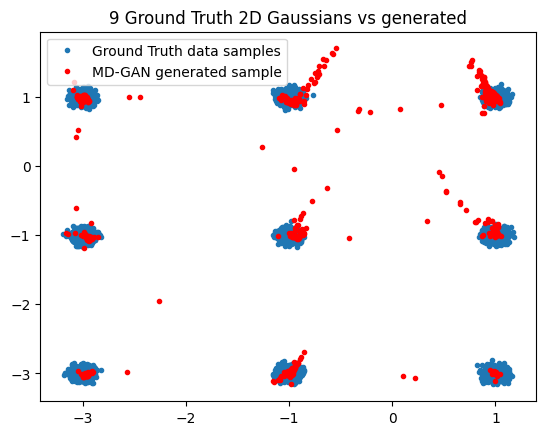

In [ ]:
from matplotlib import pyplot as plt

# With training

g_samples = net_g(torch.randn(PARAMS['batch_size'], PARAMS['zdim']).to(working_device))
g_samples = g_samples.cpu().detach().numpy()

plt.plot(training_data[:, 0], training_data[:, 1], 'o',label='Ground Truth data samples', markersize='3')
plt.plot(g_samples[:, 0], g_samples[:, 1], 'o',label='MD-GAN generated sample', color='red', markersize=3)
plt.title("9 Ground Truth 2D Gaussians vs generated")
plt.legend()
# plt.grid()
# plt.xlabel(r'$x_o$')
# plt.ylabel(r'$x_1$')
plt.show() 

# Save Generator

In [27]:
torch.save(net_g.state_dict(), 'generator_9.pt')


In [ ]:
# import torch
# import os
# import torchvision
# import torch.nn.functional as F

# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# d = 100  # dimension of latent space
# K = 11  # size of the output of discrimnator


# def D_train(x, y, G, D, GM, D_optimizer, criterion):
#     # =======================Train the discriminator=======================#
#     D.zero_grad()

#     # train discriminator on real samples
#     x_real, y_real = x, y
#     x_real, y_real = x_real.to(DEVICE), y_real.to(DEVICE)

#     D_output_real = D(x_real)
#     D_real_loss = criterion(D_output_real, y_real)

#     k_values = torch.randint(0, K, (x.shape[0],), device=DEVICE)
#     y = F.one_hot(k_values, num_classes=K).to(DEVICE).float()
#     z = torch.randn(x.shape[0], d, device=DEVICE, dtype=torch.float32)

#     # the vector of latent space sampled from the Gaussian Mixture
#     z_tilde = GM(y, z)

#     # Generate fake sample x_fake
#     x_fake = G(z_tilde)

#     D_output_fake = D(x_fake)
#     target_fake = torch.full((x.shape[0],), 10, dtype=torch.long).to(DEVICE)
#     D_fake_loss = criterion(D_output_fake, target_fake)

#     # gradient backpropagation and optimization of D's parameters
#     D_loss = D_real_loss + D_fake_loss
#     D_loss.backward()
#     D_optimizer.step()

#     return D_loss.data.item()


# def G_train(x, G, D, GM, G_optimizer, GM_optimizer, criterion):
#     # =======================Train the generator=======================#
#     G.zero_grad()
#     GM.zero_grad()

#     # representing one of the K Gaussian distributions
#     k_values = torch.randint(0, K, (x.shape[0],), device=DEVICE)
#     y = F.one_hot(k_values, num_classes=K).to(DEVICE).float()
#     z = torch.randn(x.shape[0], d, device=DEVICE, dtype=torch.float32)

#     # the vector of latent space sampled from the Gaussian Mixture
#     z_tilde = GM(y, z)
#     G_output = G(z_tilde)
#     D_output = D(G_output)

#     G_loss = criterion(D_output, k_values)

#     # gradient backpropagation and optimization of G and GM's parameters
#     G_loss.backward()
#     G_optimizer.step()
#     # GM is an extension of two layers of the generator
#     GM_optimizer.step()

#     return G_loss.data.item()


# def save_models(G, D, GM, folder):
#     torch.save(G.state_dict(), os.path.join(folder, "G.pth"))
#     torch.save(D.state_dict(), os.path.join(folder, "D.pth"))
#     torch.save(GM.state_dict(), os.path.join(folder, "GM.pth"))


# def load_model(G, GM, folder, Discriminator=None):
#     ckpt_G = torch.load(os.path.join(folder, "G.pth"))
#     ckpt_GM = torch.load(os.path.join(folder, "GM.pth"))
#     G.load_state_dict({k.replace("module.", ""): v for k, v in ckpt_G.items()})
#     GM.load_state_dict({k.replace("module.", ""): v for k, v in ckpt_GM.items()})
#     if not Discriminator == None:
#         ckpt_D = torch.load(os.path.join(folder, "D.pth"))
#         Discriminator.load_state_dict(
#             {k.replace("module.", ""): v for k, v in ckpt_D.items()}
#         )


# # Updated MNIST to PNG function
# def save_mnist_as_png(output_folder, train=True):
#     os.makedirs(output_folder, exist_ok=True)
#     dataset = torchvision.datasets.MNIST(
#         root="./data",
#         train=train,
#         download=True,
#         transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]),
#     )

#     for idx, (img, label) in enumerate(dataset):
#         img = img.squeeze(0)
#         pil_img = torchvision.transforms.ToPILImage()(img)
#         pil_img.save(f"{output_folder}/image_{idx}.png")

#     print(f"Saved {len(dataset)} images to '{output_folder}'.")


# def generate_fake_samples(generator, gm, num_samples, batch_size=2048):
#     """Function to generate fake samples using the generator"""
#     n_samples = 0
#     with torch.no_grad():
#         while n_samples < num_samples:
#             z = torch.randn(batch_size, 100).to(DEVICE)
#             k_values = torch.randint(0, 10, (batch_size,))
#             y = torch.eye(K)[k_values].to(DEVICE)
#             N = torch.distributions.MultivariateNormal(torch.zeros(d), torch.eye(d))
#             z = N.sample((batch_size,)).to(DEVICE).to(torch.float32)
#             z_tilde = gm(y, z)
#             x = generator(z_tilde)
#             x = x.reshape(batch_size, 28, 28)
#             for k in range(x.shape[0]):
#                 if n_samples < num_samples:
#                     torchvision.utils.save_image(
#                         x[k : k + 1],
#                         os.path.join("samples_train", f"{n_samples}.png"),
#                     )
#                     n_samples += 1


# if __name__ == "__main__":
#     save_mnist_as_png("real_samples")